In [47]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
# plt.style.use('seaborn-paper')
import seaborn as sns
import joblib
import joypy
# plt.rcParams['font.family']='Times New Roman,Microsoft YaHei'# 设置字体族，中文为微软雅黑，英文为Times New Roman
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # 设置数学公式字体为stix
plt.rcParams["text.usetex"] = False
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import joypy

In [48]:
datajh=pd.read_csv("groupedjhS.csv")
datacm=pd.read_csv("groupedcmS.csv")

C:\Users\aa271\AppData\Local\Temp\ipykernel_31644\3328908381.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = datajh.groupby(["Hour_Min"]).mean().reset_index()


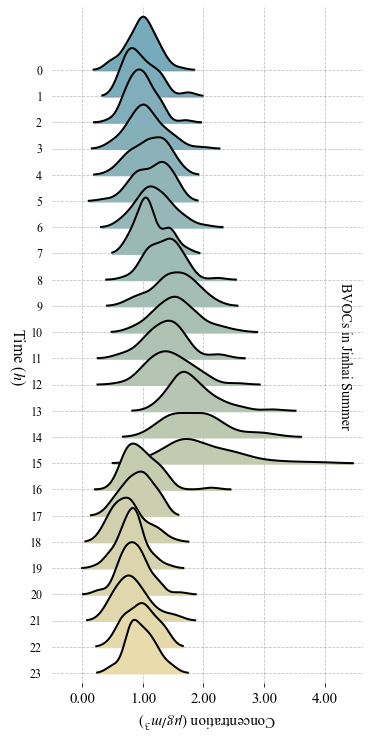

In [6]:
data = datajh.groupby(["Hour_Min"]).mean().reset_index()
data["BVOCs"]=data['异戊二烯浓度']


fig, axes = joypy.joyplot(data,
    by="Hour",
    column="异戊二烯浓度", range_style='own',
                          grid="y", linewidth=2, legend=False, figsize=(5,10),
                          title="",
                          colormap=sns.color_palette("blend:#7AB,#EDA", as_cmap=True), ylabels= "Concentration")


Hour=list(range(0,25))
# 设置 Y 轴标签为 'Concentration' 并调整网格样式
for i,ax in enumerate(axes):
    ax.grid(True, linestyle='--', color='grey', alpha=0.5)  # 设置网格样式
    ax.set_yticks([0])  # 假设每个子图的刻度位置在 0
    ax.set_yticklabels([Hour[i]])  # 为每个子图设置小时数作为 Y 轴标签
    ax.tick_params(axis='y', labelsize=12)  # 调整 Y 轴刻度标签大小



fig.text(0.9, 0.5, 'BVOCs in Jinhai Summer', va='center', rotation=270, fontsize=14)


# 设置总的 Y 轴标签
fig.text(-0.018, 0.5, 'Time ($h$)', va='center', rotation=270, fontsize=16)
# 设置 X 轴标签为 'Time'
axes[-1].set_xlabel('Concentration ($μg/m^3$)', fontsize=15, rotation=180)  # 只需在最后一个轴上设置 X 轴标签

# 设置 X 轴刻度格式为整数并调整大小
for ax in axes:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))  # 设置 X 轴刻度格式为整数
    ax.tick_params(axis='x', which='major', labelsize=15)  # 调整 X 轴刻度标签大小

# fig.savefig(f"Jinhai Ditribution BVOCs.svg", bbox_inches='tight')
# plt.show()

In [14]:
from plotnine import *
from scipy.stats import gaussian_kde, norm
from sklearn.linear_model import LinearRegression
from plotnine import ggsave
rat=1
# 计算每个分区的残差密度
def compute_density(data, section_label,rat=1,scale=1):
    if len(data['res']) > 1:
        density = gaussian_kde(data['res'])
        xs = np.linspace(data['res'].min(), data['res'].max(), 500)
        ys = density(xs)
        rescaled_x = max(data['x']) - ys * rat
        mean_y = xs + data['y'].mean()
        return pd.DataFrame({'x': rescaled_x, 'y': mean_y/scale, 'type': 'Empirical', 'group': f"{section_label}_empirical"})
    else:
        return pd.DataFrame()

def add_normal_lines(group, section_label,rat=1,scale=1):
    if len(group['res']) > 1:
        xs = np.linspace(group['res'].min(), group['res'].max(), 500)
        ys = norm.pdf(xs, 0, group['res'].std())
        rescaled_x = max(group['x']) - ys * rat
        mean_y = xs + group['y'].mean()
        return pd.DataFrame({'x': rescaled_x, 'y': mean_y/scale, 'type': 'Normal', 'group': f"{section_label}_normal"})
    else:
        return pd.DataFrame()

def remove_outliers(data, columns, iqr_factor=1.5):
    for column in columns:
        if column not in data.columns:
            raise ValueError(f"The column '{column}' does not exist in the DataFrame.")

        # Calculate Q1 and Q3 and the IQR
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define the bounds for outliers
        lower_bound = Q1 - iqr_factor * IQR
        upper_bound = Q3 + iqr_factor * IQR

        # Filter out outliers
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

        # Optional: print out the information about removed outliers
        # print(f"Outliers removed from '{column}'.")

    return data

In [4]:

data = datacm.groupby("Hour_Min").mean(numeric_only=True).reset_index()


xy=["地面层温度","异戊二烯浓度"]

# 生成数据
x = data[xy[0]].copy()
y = data[xy[1]].copy()
dat = pd.DataFrame({'x': x, 'y': y})
dat=remove_outliers(dat, ["x","y"])

# 分区
breaks = np.linspace(dat['x'].min(), dat['x'].max(), 7)
dat['section'] = pd.cut(dat['x'], breaks)

# 线性回归并计算残差
model = LinearRegression().fit(dat[['x']], dat['y'])
dat['predicted'] = model.predict(dat[['x']])
dat['res'] = dat['y'] - dat['predicted']

In [5]:
densities = pd.concat([compute_density(group, label,rat) for label, group in dat.groupby('section')])
normal_lines = pd.concat([add_normal_lines(group, label,rat) for label, group in dat.groupby('section')])
densities = pd.concat([densities, normal_lines])

C:\Users\aa271\PycharmProjects\pythonProject\venv\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 3 in image.
C:\Users\aa271\PycharmProjects\pythonProject\venv\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: cm正态回归图.svg
C:\Users\aa271\PycharmProjects\pythonProject\venv\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 3 in image.
C:\Users\aa271\PycharmProjects\pythonProject\venv\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: cm正态回归图.jpg


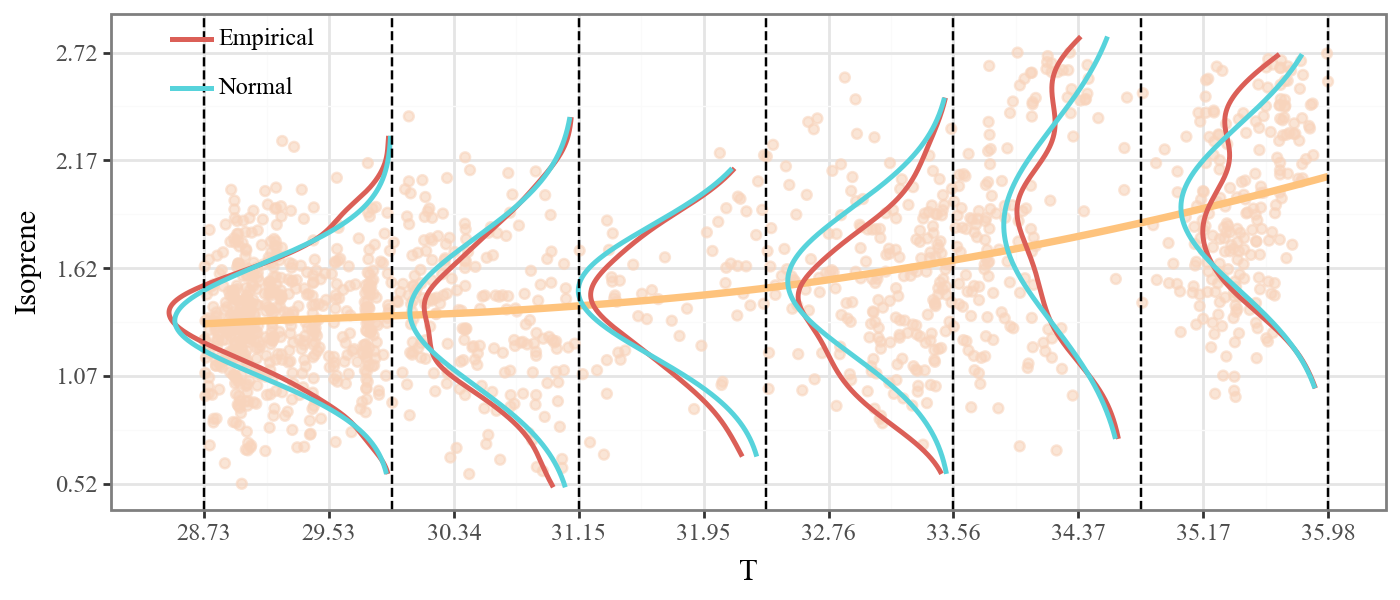

In [6]:
plot = (ggplot(dat, aes('x', 'y')) +
        geom_point(color='#F8D4BC', alpha=0.6) +
        geom_smooth(method='loess', se=False, color='#FEC37D', size=1.5) +
        geom_path(data=densities, mapping=aes('x', 'y', color='type', group='group'),size=1) +  # 使用新的 group 列
        geom_vline(xintercept=breaks, linetype="dashed") +
        labs(x='T', y='Isoprene') +
        scale_x_continuous(breaks=np.linspace(dat['x'].min(), dat['x'].max(), 10), 
                           labels=lambda x: [f'{val:.2f}' for val in x]) +  # 保留两位小数
        scale_y_continuous(breaks=np.linspace(dat['y'].min(), dat['y'].max(), 5), 
                           labels=lambda y: [f'{val:.2f}' for val in y]) +  # 保留两位小数+
        theme_bw() +
        theme(figure_size=(7, 3),
              legend_position=(0.05, 1),
              legend_title=element_blank(),
              legend_key=element_blank(),
              legend_background=element_blank(),
               text=element_text(family="Times New Roman"),  # 全局文本设置为新罗马字体
    axis_text_x=element_text(family="Times New Roman"), 
    axis_text_y=element_text(family="Times New Roman"),  
    axis_title_x=element_text(family="Times New Roman"), 
    axis_title_y=element_text(family="Times New Roman"), 
    legend_text=element_text(family="Times New Roman"))
        )

plot.save(filename="cm正态回归图.svg", dpi=600)
plot.save(filename="cm正态回归图.jpg", dpi=600)
plot.show()

In [20]:
data = datajh.groupby("Hour_Min").mean(numeric_only=True).reset_index()

xy = ["地面层温度", "异戊二烯浓度"]

# 生成数据
x = data[xy[0]].copy()
y = data[xy[1]].copy()
dat = pd.DataFrame({'x': x, 'y': y})
dat = remove_outliers(dat, ["x", "y"])

# 分区
breaks = np.linspace(dat['x'].min(), dat['x'].max(), 8)
dat['section'] = pd.cut(dat['x'], breaks)

# 线性回归并计算残差
model = LinearRegression().fit(dat[['x']], dat['y'])
dat['predicted'] = model.predict(dat[['x']])
dat['res'] = dat['y'] - dat['predicted']
densities = pd.concat([compute_density(group, label, rat=0.5) for label, group in dat.groupby('section')])
normal_lines = pd.concat([add_normal_lines(group, label, rat=0.5) for label, group in dat.groupby('section')])
densities = pd.concat([densities, normal_lines])


C:\Users\aa271\PycharmProjects\pythonProject\venv\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 3 in image.
C:\Users\aa271\PycharmProjects\pythonProject\venv\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: jh正态回归图.svg
C:\Users\aa271\PycharmProjects\pythonProject\venv\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 3 in image.
C:\Users\aa271\PycharmProjects\pythonProject\venv\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: jh正态回归图.jpg


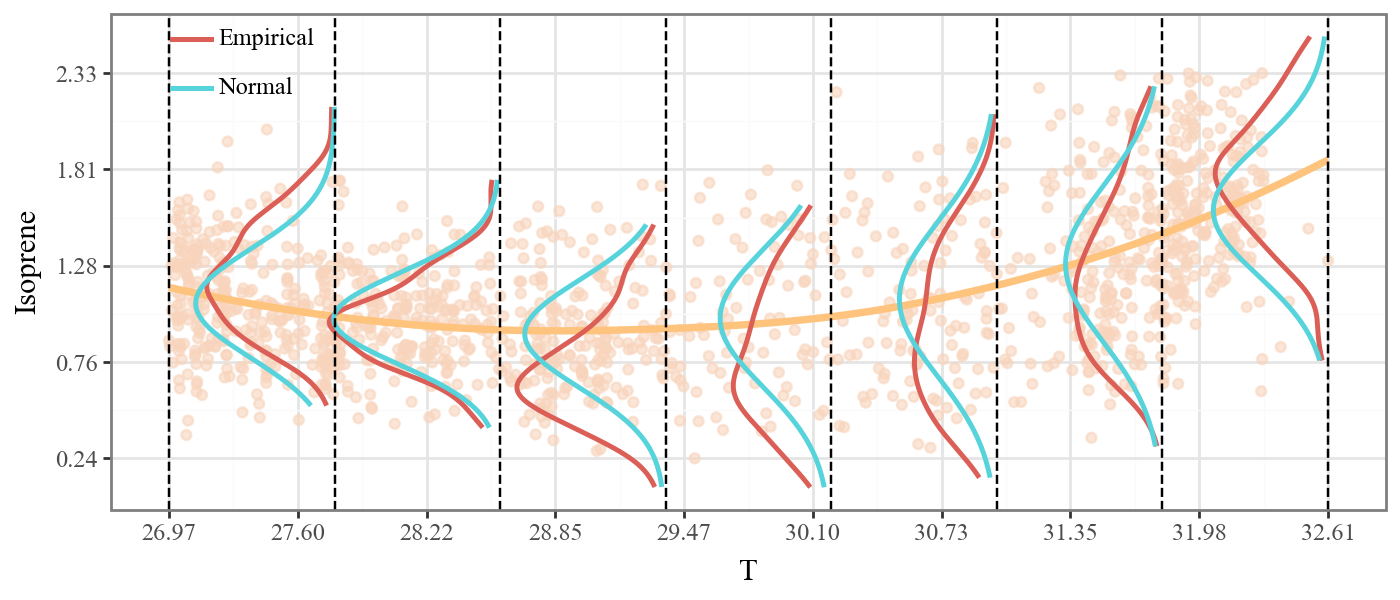

In [21]:
plot = (ggplot(dat, aes('x', 'y')) +
        geom_point(color='#F8D4BC', alpha=0.6) +
        geom_smooth(method='loess', se=False, color='#FEC37D', size=1.5) +
        geom_path(data=densities, mapping=aes('x', 'y', color='type', group='group'),size=1) +  # 使用新的 group 列
        geom_vline(xintercept=breaks, linetype="dashed") +
        labs(x='T', y='Isoprene') +
        scale_x_continuous(breaks=np.linspace(dat['x'].min(), dat['x'].max(), 10), 
                           labels=lambda x: [f'{val:.2f}' for val in x]) +  # 保留两位小数
        scale_y_continuous(breaks=np.linspace(dat['y'].min(), dat['y'].max(), 5), 
                           labels=lambda y: [f'{val:.2f}' for val in y]) +  # 保留两位小数+
        theme_bw() +
        theme(figure_size=(7, 3),
              legend_position=(0.05, 1),
              legend_title=element_blank(),
              legend_key=element_blank(),
              legend_background=element_blank(),
               text=element_text(family="Times New Roman"),  # 全局文本设置为新罗马字体
    axis_text_x=element_text(family="Times New Roman"), 
    axis_text_y=element_text(family="Times New Roman"),  
    axis_title_x=element_text(family="Times New Roman"), 
    axis_title_y=element_text(family="Times New Roman"), 
    legend_text=element_text(family="Times New Roman"))
        )

plot.save(filename="jh正态回归图.svg", dpi=600)
plot.save(filename="jh正态回归图.jpg", dpi=600)
plot.show()

In [28]:
from statsmodels.nonparametric.kernel_density import KDEMultivariateConditional
from scipy.optimize import brentq

# generate data with some autocorrelation to make it interesting
x_train = data[["地面层温度"]]
y_train = data[["O3"]]

# train conditional KDE
kde = KDEMultivariateConditional(endog=y_train, exog=x_train, dep_type='c',
                                 indep_type='c', bw='normal_reference')

def cdf_conditional(x, y_target):
    # cdf of kde conditional on x, evaluated at y_target
    return kde.cdf(np.array(y_target).reshape((-1,1)), np.array(x).reshape((-1,1)))

# inverse-transform-sampling
def sample_conditional_single(x):
    # sample conditional on x
    u = np.random.random()
    # 1-d root-finding
    def func(y):
        return cdf_conditional(x, y)- u
    sample_y = brentq(func, -99999999, 99999999)  # read brentq-docs about these constants
                                                # constants need to be sign-changing for the function
    return sample_y

def sample_conditional(x, n):
    return np.array([sample_conditional_single(x) for _ in range(n)])


# now sample at 2 different x values
x1 = 0
x2 = 2
samples1 = sample_conditional(x1, 100)
samples2 = sample_conditional(x2, 100)


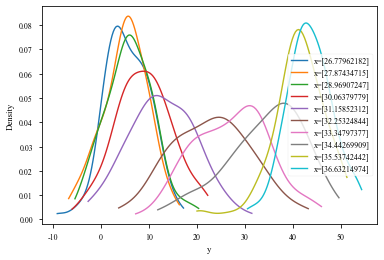

In [29]:
from scipy.stats import gaussian_kde

def plot_kde(xs, num_samples=100):
    for x in xs:
        samples = sample_conditional(x, num_samples)
        kde = gaussian_kde(samples)
        y_vals = np.linspace(min(samples), max(samples), 100)
        plt.plot(y_vals, kde(y_vals), label=f'x={x}')


# 计算 x 的均值和标准差，选择值从均值减去两倍标准差到加上两倍标准差的范围
x_mean = x_train.mean()
x_std = x_train.std()
xs = np.linspace(x_mean - 2 * x_std, x_mean + 2 * x_std, 10)  # 你可以调整这里的点数

# 绘图
plot_kde(xs)
plt.xlabel('y')
plt.ylabel('Density')
plt.legend()
plt.show()

C:\Users\aa271\AppData\Local\Temp\ipykernel_31644\82589820.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = datacm.groupby("Hour_Min").mean().reset_index()
C:\Users\aa271\PycharmProjects\pythonProject\venv\lib\site-packages\joypy\joyplot.py:582: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from current font.
  fig.tight_layout(h_pad=h_pad)
C:\Users\aa271\PycharmProjects\pythonProject\venv\lib\site-packages\joypy\joyplot.py:582: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from current font.
  fig.tight_layout(h_pad=h_pad)
C:\Users\aa271\PycharmProjects\pythonProject\venv\lib\site-packages\joypy\joyplot.py:582: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from current font.
  fig.tight_layout(h_pad=h_pad)
C:\Users\aa271\Pycha

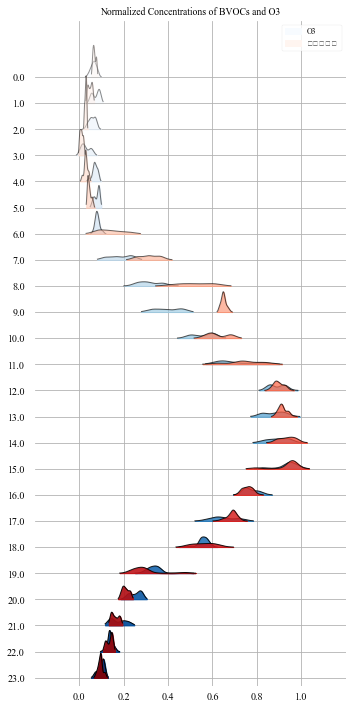

In [133]:
from sklearn.preprocessing import MinMaxScaler

data = datacm.groupby("Hour_Min").mean().reset_index()
data["BVOCs"] = data['异戊二烯浓度']
data["v"]=data["NOx"]/data["异戊二烯浓度"]
# 初始化归一化器
scaler = MinMaxScaler()

# 选择需要归一化的列
columns_to_scale = ['O3', '地面层温度']

# 对选定的列进行归一化处理
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])


# 首先创建一个figure对象
# 使用joypy创建ridge plot
axes = joypy.joyplot(
    data,
    by="Hour",
    column=["O3", "地面层温度"],
    figsize=(5, 10),
    range_style='own',
    grid=True,
    linewidth=1,
    legend=True,
    fade=True,  # 开启渐变效果增强视觉区分
    title="Normalized Concentrations of BVOCs and O3",
    colormap=[sns.color_palette("Blues", as_cmap=True),
              sns.color_palette("Reds", as_cmap=True)]
)

plt.show()

C:\Users\aa271\AppData\Local\Temp\ipykernel_27836\215878519.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = datajh.groupby(["Hour_Min"]).mean().reset_index()


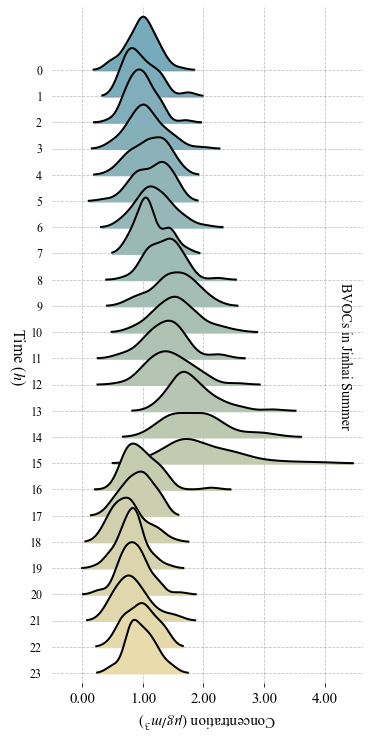

In [3]:
data = datajh.groupby(["Hour_Min"]).mean().reset_index()
data["BVOCs"]=data['异戊二烯浓度']+data["1,3-丁二烯浓度"]+data["戊烯浓度"]+data["丁烯浓度"]


fig, axes = joypy.joyplot(data,
    by="Hour",
    column="异戊二烯浓度", range_style='own',
                          grid="y", linewidth=2, legend=False, figsize=(5,10),
                          title="",
                          colormap=sns.color_palette("blend:#7AB,#EDA", as_cmap=True), ylabels= "Concentration")


Hour=list(range(0,25))
# 设置 Y 轴标签为 'Concentration' 并调整网格样式
for i,ax in enumerate(axes):
    ax.grid(True, linestyle='--', color='grey', alpha=0.5)  # 设置网格样式
    ax.set_yticks([0])  # 假设每个子图的刻度位置在 0
    ax.set_yticklabels([Hour[i]])  # 为每个子图设置小时数作为 Y 轴标签
    ax.tick_params(axis='y', labelsize=12)  # 调整 Y 轴刻度标签大小



fig.text(0.9, 0.5, 'BVOCs in Jinhai Summer', va='center', rotation=270, fontsize=14)


# 设置总的 Y 轴标签
fig.text(-0.018, 0.5, 'Time ($h$)', va='center', rotation=270, fontsize=16)
# 设置 X 轴标签为 'Time'
axes[-1].set_xlabel('Concentration ($μg/m^3$)', fontsize=15, rotation=180)  # 只需在最后一个轴上设置 X 轴标签

# 设置 X 轴刻度格式为整数并调整大小
for ax in axes:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))  # 设置 X 轴刻度格式为整数
    ax.tick_params(axis='x', which='major', labelsize=15)  # 调整 X 轴刻度标签大小

fig.savefig(f"Jinhai Ditribution BVOCs.svg", bbox_inches='tight')
plt.show()

C:\Users\aa271\AppData\Local\Temp\ipykernel_27836\2919307549.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = datajh.groupby(["Hour_Min"]).mean().reset_index()


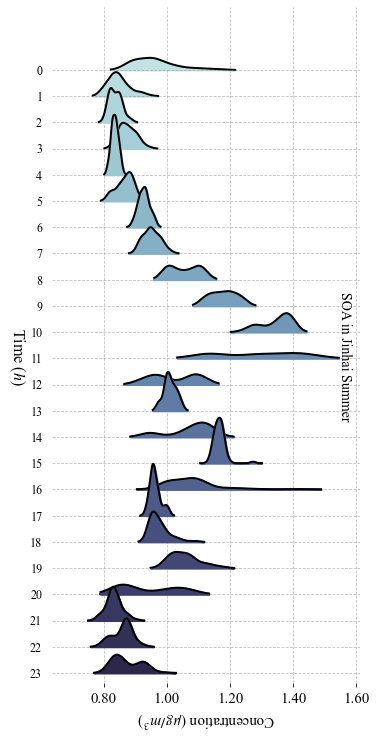

In [4]:
data = datajh.groupby(["Hour_Min"]).mean().reset_index()
data["BVOCs"]=data['异戊二烯浓度']+data["1,3-丁二烯浓度"]+data["戊烯浓度"]+data["丁烯浓度"]
data["SOA"]=0
for i in data.columns[(data.columns.get_loc("0.25um")):(data.columns.get_loc("0.28um"))]:
    data["SOA"]=data["SOA"]+data[i]

fig, axes = joypy.joyplot(data,
    by="Hour",
    column="SOA", range_style='own',
                          grid="y", linewidth=2, legend=False, figsize=(5,10),
                          title="",
                          colormap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), ylabels= "Concentration")


Hour=list(range(0,25))
# 设置 Y 轴标签为 'Concentration' 并调整网格样式
for i,ax in enumerate(axes):
    ax.grid(True, linestyle='--', color='grey', alpha=0.5)  # 设置网格样式
    ax.set_yticks([0])  # 假设每个子图的刻度位置在 0
    ax.set_yticklabels([Hour[i]])  # 为每个子图设置小时数作为 Y 轴标签
    ax.tick_params(axis='y', labelsize=12)  # 调整 Y 轴刻度标签大小



fig.text(0.9, 0.5, 'SOA in Jinhai Summer', va='center', rotation=270, fontsize=14)


# 设置总的 Y 轴标签
fig.text(-0.018, 0.5, 'Time ($h$)', va='center', rotation=270, fontsize=16)
# 设置 X 轴标签为 'Time'
axes[-1].set_xlabel('Concentration ($μg/m^3$)', fontsize=15, rotation=180)  # 只需在最后一个轴上设置 X 轴标签

# 设置 X 轴刻度格式为整数并调整大小
for ax in axes:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))  # 设置 X 轴刻度格式为整数
    ax.tick_params(axis='x', which='major', labelsize=15)  # 调整 X 轴刻度标签大小

fig.savefig(f"Jinhai Ditribution SOA.svg", bbox_inches='tight')
plt.show()

C:\Users\aa271\AppData\Local\Temp\ipykernel_27836\3068722774.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = datacm.groupby(["Hour_Min"]).mean().reset_index()


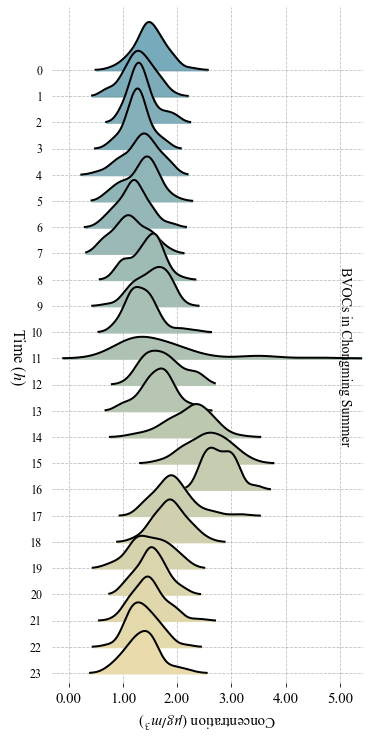

In [5]:
data = datacm.groupby(["Hour_Min"]).mean().reset_index()
data["BVOCs"]=data['异戊二烯浓度']+data["1,3-丁二烯浓度"]+data["戊烯浓度"]+data["丁烯浓度"]


fig, axes = joypy.joyplot(data,
    by="Hour",
    column="异戊二烯浓度", range_style='own',
                          grid="y", linewidth=2, legend=False, figsize=(5,10),
                          title="",
                          colormap=sns.color_palette("blend:#7AB,#EDA", as_cmap=True), ylabels= "Concentration")


Hour=list(range(0,25))
# 设置 Y 轴标签为 'Concentration' 并调整网格样式
for i,ax in enumerate(axes):
    ax.grid(True, linestyle='--', color='grey', alpha=0.5)  # 设置网格样式
    ax.set_yticks([0])  # 假设每个子图的刻度位置在 0
    ax.set_yticklabels([Hour[i]])  # 为每个子图设置小时数作为 Y 轴标签
    ax.tick_params(axis='y', labelsize=12)  # 调整 Y 轴刻度标签大小



fig.text(0.9, 0.5, 'BVOCs in Chongming Summer', va='center', rotation=270, fontsize=14)


# 设置总的 Y 轴标签
fig.text(-0.018, 0.5, 'Time ($h$)', va='center', rotation=270, fontsize=16)
# 设置 X 轴标签为 'Time'
axes[-1].set_xlabel('Concentration ($μg/m^3$)', fontsize=15, rotation=180)  # 只需在最后一个轴上设置 X 轴标签

# 设置 X 轴刻度格式为整数并调整大小
for ax in axes:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))  # 设置 X 轴刻度格式为整数
    ax.tick_params(axis='x', which='major', labelsize=15)  # 调整 X 轴刻度标签大小

fig.savefig(f"Chongming Ditribution BVOCs.svg", bbox_inches='tight')
plt.show()

C:\Users\aa271\AppData\Local\Temp\ipykernel_27836\565895143.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = datacm.groupby(["Hour_Min"]).mean().reset_index()


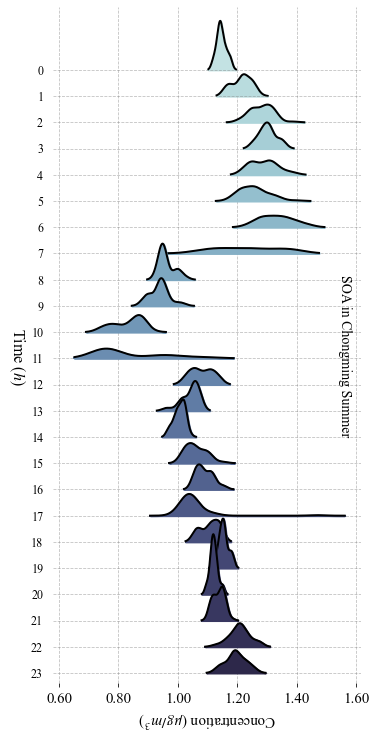

In [6]:
data = datacm.groupby(["Hour_Min"]).mean().reset_index()
data["BVOCs"]=data['异戊二烯浓度']+data["1,3-丁二烯浓度"]+data["戊烯浓度"]+data["丁烯浓度"]
data["SOA"]=0
for i in data.columns[(data.columns.get_loc("0.25um")):(data.columns.get_loc("0.28um"))]:
    data["SOA"]=data["SOA"]+data[i]

fig, axes = joypy.joyplot(data,
    by="Hour",
    column="SOA", range_style='own',
                          grid="y", linewidth=2, legend=False, figsize=(5,10),
                          title="",
                          colormap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), ylabels= "Concentration")


Hour=list(range(0,25))
# 设置 Y 轴标签为 'Concentration' 并调整网格样式
for i,ax in enumerate(axes):
    ax.grid(True, linestyle='--', color='grey', alpha=0.5)  # 设置网格样式
    ax.set_yticks([0])  # 假设每个子图的刻度位置在 0
    ax.set_yticklabels([Hour[i]])  # 为每个子图设置小时数作为 Y 轴标签
    ax.tick_params(axis='y', labelsize=12)  # 调整 Y 轴刻度标签大小



fig.text(0.9, 0.5, 'SOA in Chongming Summer', va='center', rotation=270, fontsize=14)


# 设置总的 Y 轴标签
fig.text(-0.018, 0.5, 'Time ($h$)', va='center', rotation=270, fontsize=16)
# 设置 X 轴标签为 'Time'
axes[-1].set_xlabel('Concentration ($μg/m^3$)', fontsize=15, rotation=180)  # 只需在最后一个轴上设置 X 轴标签

# 设置 X 轴刻度格式为整数并调整大小
for ax in axes:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))  # 设置 X 轴刻度格式为整数
    ax.tick_params(axis='x', which='major', labelsize=15)  # 调整 X 轴刻度标签大小

fig.savefig(f"Chongming Ditribution SOA.svg", bbox_inches='tight')
plt.show()

In [49]:
from scipy.stats import norm, expon, gamma, lognorm, beta, kstest,shapiro

def normal_distribution_fit_and_test(grouped_by_hour):
    normality_results = {}
    for hour, group in grouped_by_hour:
        # Fit normal distribution and get parameters
        params = norm.fit(group)
        # Perform Shapiro-Wilk test
        _, p_value = shapiro(group)
        # Check if data is normally distributed based on p-value
        is_normal = True if p_value > 0.05 else False
        normality_results[hour] = (params[0], params[1], p_value, is_normal)  # params[0]: mean, params[1]: standard deviation

    normality_df = pd.DataFrame(normality_results).T
    normality_df.columns = ["Mean", "Standard Deviation", "P-Value", "Is Normal"]
    normality_df.reset_index(inplace=True)
    normality_df.rename(columns={'index': 'Hour'}, inplace=True)

    return normality_df

# Group data by hour
data=datajh.groupby(["Hour_Min"]).mean().reset_index()
# data["BVOCs"]=data['异戊二烯浓度']+data["1,3-丁二烯浓度"]+data["戊烯浓度"]+data["丁烯浓度"]
data["BVOCs"]=data['异戊二烯浓度']
grouped_by_hour = data.groupby('Hour')
normality_df=normal_distribution_fit_and_test(grouped_by_hour["异戊二烯浓度"])
normality_df['T']=data.groupby('Hour').mean()["地面层温度"]

C:\Users\aa271\AppData\Local\Temp\ipykernel_30020\3747546916.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=datajh.groupby(["Hour_Min"]).mean().reset_index()
C:\Users\aa271\AppData\Local\Temp\ipykernel_30020\3747546916.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  normality_df['T']=data.groupby('Hour').mean()["地面层温度"]


In [50]:
from scipy.optimize import curve_fit

# 定义与均值 Mean 的关系的函数
def mean_relation(T, Q0, a, v0):
    return Q0 + (a * T**2) / 2 + T * v0

# 定义与方差 variance 的关系的函数
def std_dev_relation(T, k, sigma0):
    return ((k**2) * (T**3) )/ 3 + k * (T**2) * sigma0 + T*(sigma0**2)




# 提取数据
T = normality_df['T'].values
mean_values = normality_df['Mean'].astype("float").values
std_dev_values = normality_df['Standard Deviation'].astype("float").values**2

In [51]:

from scipy.stats import zscore
from scipy.stats import t


# 定义去除离群值的函数（使用 Z-score 方法）
def remove_outliers(data):
    z_scores = zscore(data)
    return data[(np.abs(z_scores) < 3)]  # 通常使用 3 作为 Z-score 的阈值


# 对 Mean 和 Standard Deviation 值应用四分位数法去除离群值
mean_values_filtered = remove_outliers(mean_values)
std_dev_values_filtered = remove_outliers(std_dev_values)

# 为过滤后的数据创建对应的 T 值数组
T_filtered_mean = T[np.isin(mean_values, mean_values_filtered)]
T_filtered_std_dev = T[np.isin(std_dev_values, std_dev_values_filtered)]


# 重新进行稳健拟合
params_mean_filtered, covariance_mean = curve_fit(mean_relation, T_filtered_mean, mean_values_filtered, method='trf')
params_std_dev_filtered, covariance_std_dev = curve_fit(std_dev_relation, T_filtered_std_dev, std_dev_values_filtered, method='trf')


# 计算标准误差
std_errors_mean = np.sqrt(np.diag(covariance_mean))
std_errors_std_dev = np.sqrt(np.diag(covariance_std_dev))

# 计算 t 统计量
t_values_mean = params_mean_filtered / std_errors_mean
t_values_std_dev = params_std_dev_filtered / std_errors_std_dev

# 计算自由度
n_mean = len(T_filtered_mean)
n_std_dev = len(T_filtered_std_dev)
p_mean = len(params_mean_filtered)  # 参数数量
p_std_dev = len(params_std_dev_filtered)
dof_mean = max(0, n_mean - p_mean)  # 自由度 = 样本数 - 参数数
dof_std_dev = max(0, n_std_dev - p_std_dev)

# 计算 P 值
p_values_mean = 2 * (1 - t.cdf(np.abs(t_values_mean), dof_mean))
p_values_std_dev = 2 * (1 - t.cdf(np.abs(t_values_std_dev), dof_std_dev))


# 计算残差
residuals = mean_values_filtered - mean_relation(T_filtered_mean, *params_mean_filtered)
# 计算残差平方和 (SS_res) 和总平方和 (SS_tot)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((mean_values_filtered - np.mean(mean_values_filtered))**2)
# 计算 R² 值
r_squared = 1 - (ss_res / ss_tot)
    

# 计算残差
residuals = std_dev_values_filtered - std_dev_relation(T_filtered_std_dev, *params_std_dev_filtered)
# 计算残差平方和 (SS_res) 和总平方和 (SS_tot)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((std_dev_values_filtered - np.mean(std_dev_values_filtered))**2)
# 计算 R² 值
r_squared2 = 1 - (ss_res / ss_tot)

# # 显著性检验
# p_values_mean = np.diag(covariance_mean)
# p_values_std_dev = np.diag(covariance_std_dev)

# 输出拟合参数和显著性
print("Mean relation parameters (filtered):", params_mean_filtered, "P-values:", p_values_mean)
print("Standard Deviation relation parameters (filtered):", params_std_dev_filtered, "P-values:", p_values_std_dev)

Mean relation parameters (filtered): [67.64145692  0.15928495 -4.61119805] P-values: [0.00167257 0.00125272 0.00155783]
Standard Deviation relation parameters (filtered): [ 0.00579244 -0.06298054] P-values: [0.21305004 0.67987509]


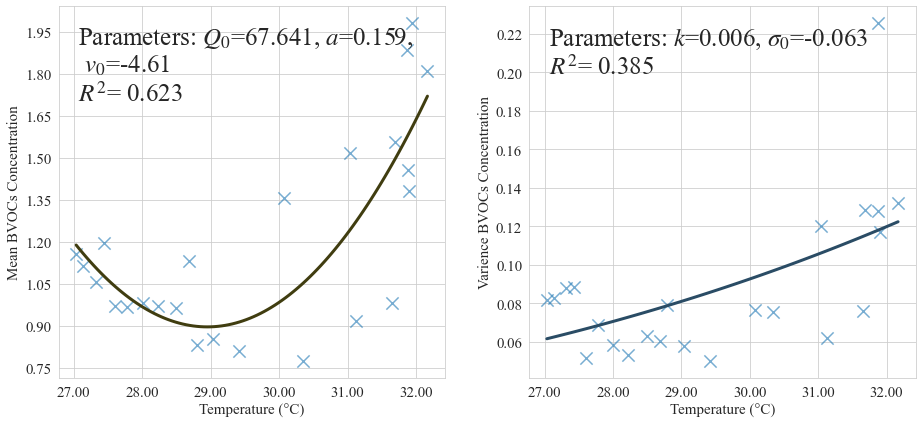

In [52]:

# 首先对 T 进行排序，以避免绘图时出现折线
T_sorted = np.sort(T)
T_plot=np.linspace(T_sorted.min(),T_sorted.max(),100)
# 使用排序后的 T 来计算拟合曲线和置信区间
mean_fit_sorted = mean_relation(T_plot, *params_mean_filtered)
std_dev_fit_sorted = std_dev_relation(T_plot, *params_std_dev_filtered)


# 绘制 Mean 关系图
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ax[0].scatter(T_filtered_mean, mean_values_filtered, label='Filtered Observations', alpha=0.6, marker='x',s=150)
sns.lineplot(x=T_plot, y=mean_fit_sorted, color='#403D10', label='Fitted Curve',ax=ax[0],linewidth=3)
# ax[0].set_title('Mean Relation')
# ax[0].text(0.05, 0.95, f'Parameters: $Q_0$={params_mean_filtered[0]:.3f}, $a$={params_mean_filtered[1]:.3f}, $v_0$={params_mean_filtered[2]:.2f}\n'
#          f'P-values: {p_values_mean[0]:.3f}, {p_values_mean[1]:.3f}, {p_values_mean[2]:.3f}'f'\n$R^2$= {r_squared:.3f}',
#          transform=ax[0].transAxes, verticalalignment='top',fontsize=20)
ax[0].text(0.05, 0.95, f'Parameters: $Q_0$={params_mean_filtered[0]:.3f}, $a$={params_mean_filtered[1]:.3f},\n $v_0$={params_mean_filtered[2]:.2f}\n'f'$R^2$= {r_squared:.3f}',
         transform=ax[0].transAxes, verticalalignment='top',fontsize=25)

# 绘制 Standard Deviation 关系图
ax[1].scatter(T_filtered_std_dev, std_dev_values_filtered, label='Filtered Observations', alpha=0.6, marker='x',s=150)
sns.lineplot(x=T_plot, y=std_dev_fit_sorted, color='#2A4C65', label='Fitted Curve',ax=ax[1],linewidth=3)
# ax[1].set_title('Varience Relation')
# ax[1].text(0.05, 0.95, f'Parameters: $k$={params_std_dev_filtered[0]:.3f}, $σ_0$={params_std_dev_filtered[1]:.3f}\n'
#          f'P-values: {p_values_std_dev[0]:.3f}, {p_values_std_dev[1]:.3f}',   
#          transform=ax[1].transAxes, verticalalignment='top',fontsize=20)
ax[1].text(0.05, 0.95, f'Parameters: $k$={params_std_dev_filtered[0]:.3f}, $σ_0$={params_std_dev_filtered[1]:.3f}\n'f'$R^2$= {r_squared2:.3f}',
         transform=ax[1].transAxes, verticalalignment='top',fontsize=25)

ax[0].set_xlabel("Temperature (°C)", fontsize=15)  # 假设地面层温度的单位是°C
ax[0].set_ylabel("Mean BVOCs Concentration", fontsize=15)
ax[1].set_xlabel("Temperature (°C)", fontsize=15)  # 假设地面层温度的单位是°C
ax[1].set_ylabel("Varience BVOCs Concentration", fontsize=15)

ax[1].legend().remove()
ax[0].legend().remove()

for axi in ax:
    def format_ticks(x, pos):
        return f'{x:.2f}'  # 这里设置为保留两位小数，您可以根据需要进行修改
    from matplotlib.ticker import FuncFormatter, MaxNLocator, ScalarFormatter
    # 设置x轴刻度的格式
    axi.yaxis.set_major_formatter(FuncFormatter(format_ticks))
    axi.xaxis.set_major_formatter(FuncFormatter(format_ticks))
    axi.yaxis.set_major_locator(MaxNLocator(nbins=12))
    axi.xaxis.set_major_locator(MaxNLocator(nbins=7))
    axi.tick_params(axis='both', labelsize=15)



plt.tight_layout()
plt.savefig(f"Jinhai BVOCs fit.svg", bbox_inches='tight')
plt.show()


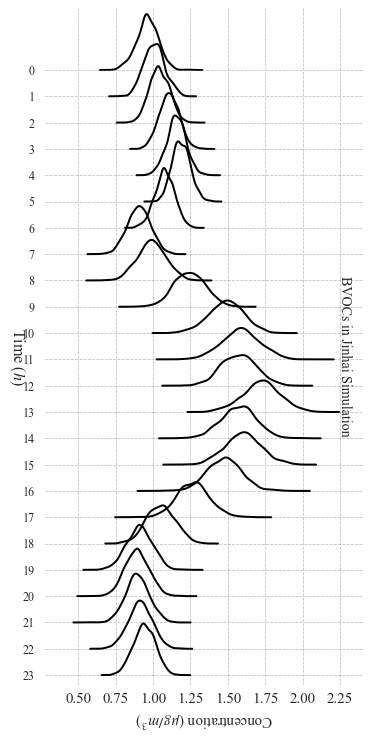

In [54]:
dt = 1
times = np.arange(0, 24, dt)
T_values = normality_df['T'].values

def simulate_path():
    S = []
    for i in range(0, len(times)):
        t = times[i]
        T = T_values[i]
        mu = mean_relation(T, *params_mean_filtered)
        sigma = std_dev_relation(T, *params_std_dev_filtered)
        S.append(np.random.normal(mu, sigma, 1)[0])
    return S


n_simulations = 1000
# 模拟多次并转换为DataFrame
data_list = []
i=0
for _ in range(n_simulations):
    path = simulate_path()
    for t, s in zip(times, path):
        data_list.append({'Hour': t, 'BVOCs': s,"group":i})
    i+=1

datasimu = pd.DataFrame(data_list)



fig, axes = joypy.joyplot(datasimu,
    by="Hour",
    column="BVOCs", range_style='own',
                          grid="y", linewidth=2, legend=False, figsize=(5,10),
                          title="",
                          colormap=sns.color_palette("blend:#7AB,#EDA", as_cmap=True), ylabels= "Concentration",
    linecolor='black',fill=False)

Hour=list(range(0,25))
# 设置 Y 轴标签为 'Concentration' 并调整网格样式
for i,ax in enumerate(axes):
    ax.grid(True, linestyle='--', color='grey', alpha=0.5)  # 设置网格样式
    ax.set_yticks([0])  # 假设每个子图的刻度位置在 0
    ax.set_yticklabels([Hour[i]])  # 为每个子图设置小时数作为 Y 轴标签
    ax.tick_params(axis='y', labelsize=12)  # 调整 Y 轴刻度标签大小



fig.text(0.9, 0.5, 'BVOCs in Jinhai Simulation', va='center', rotation=270, fontsize=14)


# 设置总的 Y 轴标签
fig.text(-0.018, 0.5, 'Time ($h$)', va='center', rotation=270, fontsize=16)
# 设置 X 轴标签为 'Time'
axes[-1].set_xlabel('Concentration ($μg/m^3$)', fontsize=15, rotation=180)  # 只需在最后一个轴上设置 X 轴标签

# 设置 X 轴刻度格式为整数并调整大小
for ax in axes:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))  # 设置 X 轴刻度格式为整数
    ax.tick_params(axis='x', which='major', labelsize=15)  # 调整 X 轴刻度标签大小

fig.savefig(f"Jinhai Ditribution BVOCs Simu.svg", bbox_inches='tight')
plt.show()

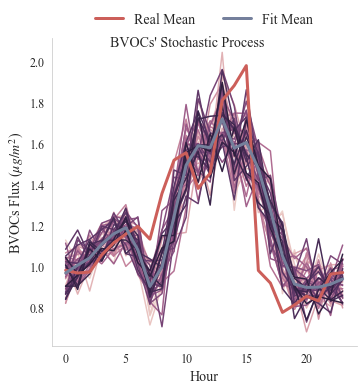

In [53]:
n_simulations = 50
# 模拟多次并转换为DataFrame
data_list = []
i=0
for _ in range(n_simulations):
    path = simulate_path()
    for t, s in zip(times, path):
        data_list.append({'Hour': t, 'BVOCs': s,"group":i})
    i+=1

datasimu = pd.DataFrame(data_list)

# Plot the lines on two facets
g = sns.relplot(x="Hour", y="BVOCs",
                hue="group", facet_kws=dict(sharex=False),
                kind="line", data=datasimu,
    legend=False)

mu = mean_relation(normality_df["T"], *params_mean_filtered)

sns.lineplot(x=normality_df["Hour"],y=normality_df["Mean"],label="Real Mean",linewidth=3,color="#CC5F5A")
sns.lineplot(x=normality_df["Hour"],y=mu,label="Fit Mean",linewidth=3,color="#75809C")

# Set the title
g.fig.suptitle("BVOCs' Stochastic Process",fontsize=14)

# Set the y-axis label
g.axes[0, 0].set_ylabel("BVOCs Flux ($μg/m^2$)",fontsize=14)
g.axes[0, 0].set_xlabel("Hour",fontsize=14)
plt.grid()

g.tick_params(axis='y', labelsize=12)  # 调整 Y 轴刻度标签大小
g.tick_params(axis='x', labelsize=12)  # 调整 Y 轴刻度标签大小

plt.legend(title='', frameon=False, loc="lower center", fontsize=14, ncol=2, bbox_to_anchor=(0.5, 1))
plt.savefig(f"Jinhai Ditribution BVOCs Simu2.svg", bbox_inches='tight')

In [55]:
from scipy.stats import t


# Group data by hour
data=datacm.groupby(["Hour_Min"]).mean().reset_index()
data["BVOCs"]=data['异戊二烯浓度']
grouped_by_hour = data.groupby('Hour')
normality_df=normal_distribution_fit_and_test(grouped_by_hour["异戊二烯浓度"])
normality_df['T']=data.groupby('Hour').mean()["地面层温度"]

# 提取数据
T = normality_df['T'].values
mean_values = normality_df['Mean'].astype("float").values
std_dev_values = normality_df['Standard Deviation'].astype("float").values**2

# 对 Mean 和 Standard Deviation 值应用四分位数法去除离群值
mean_values_filtered = remove_outliers(mean_values)
std_dev_values_filtered = remove_outliers(std_dev_values)

# 为过滤后的数据创建对应的 T 值数组
T_filtered_mean = T[np.isin(mean_values, mean_values_filtered)]
T_filtered_std_dev = T[np.isin(std_dev_values, std_dev_values_filtered)]


# 重新进行稳健拟合
params_mean_filtered, covariance_mean = curve_fit(mean_relation, T_filtered_mean, mean_values_filtered, method='trf')
params_std_dev_filtered, covariance_std_dev = curve_fit(std_dev_relation, T_filtered_std_dev, std_dev_values_filtered, method='trf')


# 计算标准误差
std_errors_mean = np.sqrt(np.diag(covariance_mean))
std_errors_std_dev = np.sqrt(np.diag(covariance_std_dev))

# 计算 t 统计量
t_values_mean = params_mean_filtered / std_errors_mean
t_values_std_dev = params_std_dev_filtered / std_errors_std_dev

# 计算自由度
n_mean = len(T_filtered_mean)
n_std_dev = len(T_filtered_std_dev)
p_mean = len(params_mean_filtered)  # 参数数量
p_std_dev = len(params_std_dev_filtered)
dof_mean = max(0, n_mean - p_mean)  # 自由度 = 样本数 - 参数数
dof_std_dev = max(0, n_std_dev - p_std_dev)

# 计算 P 值
p_values_mean = 2 * (1 - t.cdf(np.abs(t_values_mean), dof_mean))
p_values_std_dev = 2 * (1 - t.cdf(np.abs(t_values_std_dev), dof_std_dev))


# 计算残差
residuals = mean_values_filtered - mean_relation(T_filtered_mean, *params_mean_filtered)
# 计算残差平方和 (SS_res) 和总平方和 (SS_tot)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((mean_values_filtered - np.mean(mean_values_filtered))**2)
# 计算 R² 值
r_squared = 1 - (ss_res / ss_tot)
    

# 计算残差
residuals = std_dev_values_filtered - std_dev_relation(T_filtered_std_dev, *params_std_dev_filtered)
# 计算残差平方和 (SS_res) 和总平方和 (SS_tot)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((std_dev_values_filtered - np.mean(std_dev_values_filtered))**2)
# 计算 R² 值
r_squared2 = 1 - (ss_res / ss_tot)



# # 显著性检验
# p_values_mean = np.diag(covariance_mean)
# p_values_std_dev = np.diag(covariance_std_dev)

# 输出拟合参数和显著性
print("Mean relation parameters (filtered):", params_mean_filtered, "P-values:", p_values_mean)
print("Standard Deviation relation parameters (filtered):", params_std_dev_filtered, "P-values:", p_values_std_dev)

Mean relation parameters (filtered): [16.8412837   0.03708182 -1.07192586] P-values: [0.29981812 0.24405826 0.29249882]
Standard Deviation relation parameters (filtered): [0.00174407 0.02391389] P-values: [0.04981421 0.14923511]


C:\Users\aa271\AppData\Local\Temp\ipykernel_30020\484532795.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=datacm.groupby(["Hour_Min"]).mean().reset_index()
C:\Users\aa271\AppData\Local\Temp\ipykernel_30020\484532795.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  normality_df['T']=data.groupby('Hour').mean()["地面层温度"]


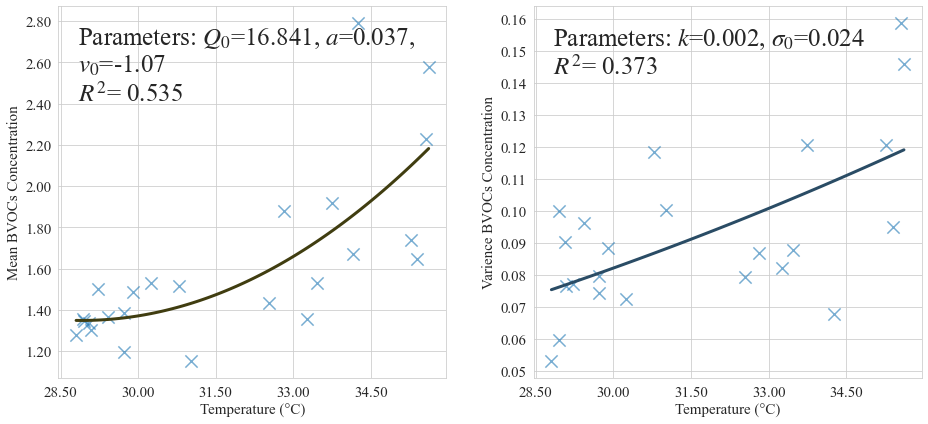

In [56]:
# 首先对 T 进行排序，以避免绘图时出现折线
T_sorted = np.sort(T)

T_plot=np.linspace(T_sorted.min(),T_sorted.max(),100)
# 使用排序后的 T 来计算拟合曲线和置信区间
mean_fit_sorted = mean_relation(T_plot, *params_mean_filtered)
std_dev_fit_sorted = std_dev_relation(T_plot, *params_std_dev_filtered)


# 绘制 Mean 关系图
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ax[0].scatter(T_filtered_mean, mean_values_filtered, label='Filtered Observations', alpha=0.6, marker='x',s=150)
sns.lineplot(x=T_plot, y=mean_fit_sorted, color='#403D10', label='Fitted Curve',ax=ax[0],linewidth=3)
# ax[0].set_title('Mean Relation')
# ax[0].text(0.05, 0.95, f'Parameters: $Q_0$={params_mean_filtered[0]:.3f}, $a$={params_mean_filtered[1]:.3f}, $v_0$={params_mean_filtered[2]:.2f}\n'
#          f'P-values: {p_values_mean[0]:.3f}, {p_values_mean[1]:.3f}, {p_values_mean[2]:.3f}'f'\n$R^2$= {r_squared:.3f}',
#          transform=ax[0].transAxes, verticalalignment='top',fontsize=20)
ax[0].text(0.05, 0.95, f'Parameters: $Q_0$={params_mean_filtered[0]:.3f}, $a$={params_mean_filtered[1]:.3f}, \n$v_0$={params_mean_filtered[2]:.2f}\n'f'$R^2$= {r_squared:.3f}',
         transform=ax[0].transAxes, verticalalignment='top',fontsize=25)

# 绘制 Standard Deviation 关系图
ax[1].scatter(T_filtered_std_dev, std_dev_values_filtered, label='Filtered Observations', alpha=0.6, marker='x',s=150)
sns.lineplot(x=T_plot, y=std_dev_fit_sorted, color='#2A4C65', label='Fitted Curve',ax=ax[1],linewidth=3)
# ax[1].set_title('Varience Relation')
# ax[1].text(0.05, 0.95, f'Parameters: $k$={params_std_dev_filtered[0]:.3f}, $σ_0$={params_std_dev_filtered[1]:.3f}\n'
#          f'P-values: {p_values_std_dev[0]:.3f}, {p_values_std_dev[1]:.3f}',   
#          transform=ax[1].transAxes, verticalalignment='top',fontsize=20)
ax[1].text(0.05, 0.95, f'Parameters: $k$={params_std_dev_filtered[0]:.3f}, $σ_0$={params_std_dev_filtered[1]:.3f}\n'f'$R^2$= {r_squared2:.3f}',
         transform=ax[1].transAxes, verticalalignment='top',fontsize=25)


ax[0].set_xlabel("Temperature (°C)", fontsize=15)  # 假设地面层温度的单位是°C
ax[0].set_ylabel("Mean BVOCs Concentration", fontsize=15)
ax[1].set_xlabel("Temperature (°C)", fontsize=15)  # 假设地面层温度的单位是°C
ax[1].set_ylabel("Varience BVOCs Concentration", fontsize=15)

ax[1].legend().remove()
ax[0].legend().remove()

for axi in ax:
    def format_ticks(x, pos):
        return f'{x:.2f}'  # 这里设置为保留两位小数，您可以根据需要进行修改
    from matplotlib.ticker import FuncFormatter, MaxNLocator, ScalarFormatter
    # 设置x轴刻度的格式
    axi.yaxis.set_major_formatter(FuncFormatter(format_ticks))
    axi.xaxis.set_major_formatter(FuncFormatter(format_ticks))
    axi.yaxis.set_major_locator(MaxNLocator(nbins=12))
    axi.xaxis.set_major_locator(MaxNLocator(nbins=7))
    axi.tick_params(axis='both', labelsize=15)

plt.tight_layout()
plt.savefig(f"Chongming BVOCs fit.svg", bbox_inches='tight')
plt.show()

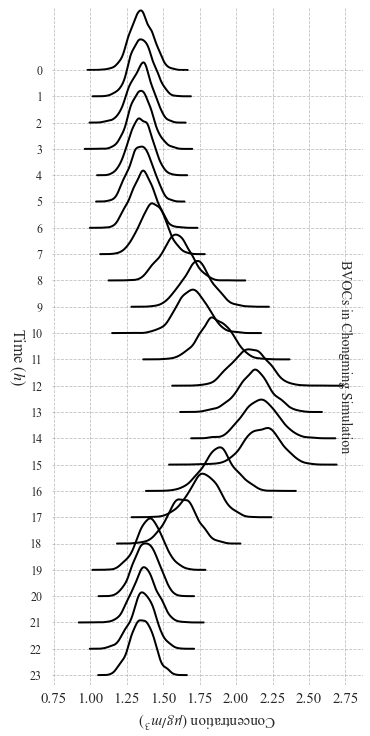

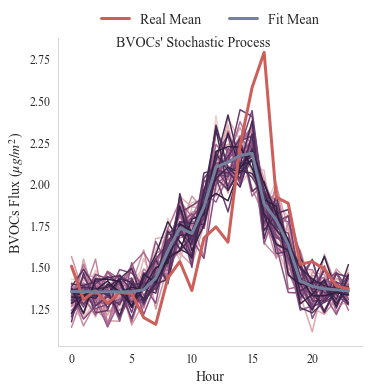

In [57]:
dt = 1
times = np.arange(0, 24, dt)
T_values = normality_df['T'].values


def simulate_path():
    S = []
    for i in range(0, len(times)):
        t = times[i]
        T = T_values[i]
        mu = mean_relation(T, *params_mean_filtered)
        sigma = std_dev_relation(T, *params_std_dev_filtered)
        S.append(np.random.normal(mu, sigma, 1)[0])
    return S


n_simulations = 1000
# 模拟多次并转换为DataFrame
data_list = []
i = 0
for _ in range(n_simulations):
    path = simulate_path()
    for t, s in zip(times, path):
        data_list.append({'Hour': t, 'BVOCs': s, "group": i})
    i += 1

datasimu = pd.DataFrame(data_list)

fig, axes = joypy.joyplot(datasimu,
                          by="Hour",
                          column="BVOCs", range_style='own',
                          grid="y", linewidth=2, legend=False, figsize=(5, 10),
                          title="",
                          colormap=sns.color_palette("blend:#7AB,#EDA", as_cmap=True), ylabels="Concentration",
                          linecolor='black', fill=False)

Hour = list(range(0, 25))
# 设置 Y 轴标签为 'Concentration' 并调整网格样式
for i, ax in enumerate(axes):
    ax.grid(True, linestyle='--', color='grey', alpha=0.5)  # 设置网格样式
    ax.set_yticks([0])  # 假设每个子图的刻度位置在 0
    ax.set_yticklabels([Hour[i]])  # 为每个子图设置小时数作为 Y 轴标签
    ax.tick_params(axis='y', labelsize=12)  # 调整 Y 轴刻度标签大小

fig.text(0.9, 0.5, 'BVOCs in Chongming Simulation', va='center', rotation=270, fontsize=14)

# 设置总的 Y 轴标签
fig.text(-0.018, 0.5, 'Time ($h$)', va='center', rotation=270, fontsize=16)
# 设置 X 轴标签为 'Time'
axes[-1].set_xlabel('Concentration ($μg/m^3$)', fontsize=15, rotation=180)  # 只需在最后一个轴上设置 X 轴标签

# 设置 X 轴刻度格式为整数并调整大小
for ax in axes:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))  # 设置 X 轴刻度格式为整数
    ax.tick_params(axis='x', which='major', labelsize=15)  # 调整 X 轴刻度标签大小

fig.savefig(f"Chongming Ditribution BVOCs Simu.svg", bbox_inches='tight')
plt.show()
n_simulations = 50
# 模拟多次并转换为DataFrame
data_list = []
i = 0
for _ in range(n_simulations):
    path = simulate_path()
    for t, s in zip(times, path):
        data_list.append({'Hour': t, 'BVOCs': s, "group": i})
    i += 1

datasimu = pd.DataFrame(data_list)

# Plot the lines on two facets
g = sns.relplot(x="Hour", y="BVOCs",
                hue="group", facet_kws=dict(sharex=False),
                kind="line", data=datasimu,
                legend=False)

mu = mean_relation(normality_df["T"], *params_mean_filtered)

sns.lineplot(x=normality_df["Hour"], y=normality_df["Mean"], label="Real Mean", linewidth=3, color="#CC5F5A")
sns.lineplot(x=normality_df["Hour"], y=mu, label="Fit Mean", linewidth=3, color="#75809C")

# Set the title
g.fig.suptitle("BVOCs' Stochastic Process", fontsize=14)

# Set the y-axis label
g.axes[0, 0].set_ylabel("BVOCs Flux ($μg/m^2$)", fontsize=14)
g.axes[0, 0].set_xlabel("Hour", fontsize=14)
plt.grid()

g.tick_params(axis='y', labelsize=12)  # 调整 Y 轴刻度标签大小
g.tick_params(axis='x', labelsize=12)  # 调整 Y 轴刻度标签大小

plt.legend(title='', frameon=False, loc="lower center", fontsize=14, ncol=2, bbox_to_anchor=(0.5, 1))
plt.savefig(f"Chongming Ditribution BVOCs Simu2.svg", bbox_inches='tight')